In [2]:
import sys
sys.path.append('/Users/nwilming/u')
import cPickle
from conf_analysis import behavior
from conf_analysis.pupil import pupil, patsy_transforms as pt
from conf_analysis.behavior import empirical
from pylab import *
import seaborn as sns
import pandas as pd
%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set_style('ticks')

/Users/nwilming/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data = empirical.load_data()
data = empirical.data_cleanup(data)

In [4]:
dz = empirical.zscore(data)

In [5]:
data['conf_0index'] = data.confidence-1
dz['conf_0index'] = dz.confidence-1

In [28]:
edges = arange(-2.5,2.6, 1)
edges

array([-2.5, -1.5, -0.5,  0.5,  1.5,  2.5])

In [67]:
palette = {0.05: behavior.color_palette2['Primary'][0], 
           0.10: behavior.color_palette2['Secondary1'][0],
           0.15: behavior.color_palette2['Secondary2'][0]}


edges = arange(-2.25,2.5, .5)
dz.loc[:, 'emp_noise_sigma'] = empirical.cut(dz.stdc, percentile(dz.stdc.values, [0, 100/3., 200/3., 300/3.]))

dlin_tertiles = (dz.groupby(['snum', 'session_num', 'block_num'])
         .apply(lambda x: empirical.qcut(x, edges, 'lincon'))
         .groupby(['lincon', 'snum', 'emp_noise_sigma', 'session_num', 'block_num'])
         .median()
         .reset_index())


dlin_tertiles_sub = (dz.groupby(['snum', 'session_num', 'block_num'])
         .apply(lambda x: empirical.qcut(x, linspace(-3.5,3.5,3), 'lincon'))
         .groupby(['lincon', 'snum', 'emp_noise_sigma', 'session_num', 'block_num'])
         .median()
         .reset_index())


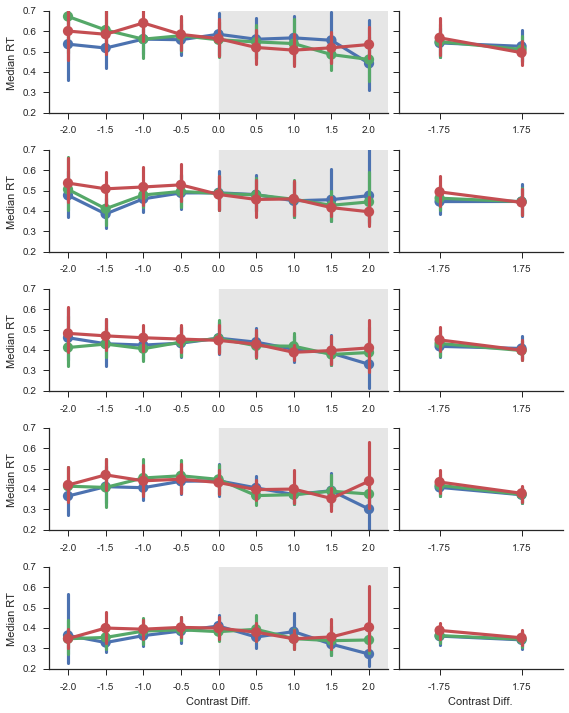

In [83]:
gs = matplotlib.gridspec.GridSpec(5, 3)
figure(figsize=(8, 10))

for session in range(5):
    for data, pos, field in zip([dlin_tertiles.query('session_num==%i'%session), 
                                 dlin_tertiles_sub.query('session_num==%i'%session)],
                            [(session, slice(0,2)), (session,2)],
                            ['emp_noise_sigma', 'emp_noise_sigma']):
        subplot(gs[pos[0], pos[1]])
        sns.pointplot(x='lincon', y='choice_rt', hue=field, units='snum', ci=95, data=data)#, palette=palette)
        ylabel('Median RT')
        legend('')
        if pos[0] == 5:
            xlabel('Contrast diff.')
        ylim([0.2, .7])
        zpos = mean(xlim())
        gca().add_patch(Rectangle((4., .0) , 4.5,1, color=(.9, .9, .9), zorder=-1))
        sns.despine(ax=gca())
        if pos[1]==2:
            ylabel('')
            yticks([.2, .3, .4, .5, .6, .7], [])
        if session<4:
            xlabel('')
        else:
            xlabel('Contrast Diff.')
tight_layout()
savefig('/Users/nwilming/u/conf_analysis/plots/rt.pdf', bbox_to_inches='tight')

In [73]:
edges = arange(-2.25,2.5, .5)[1:-1]

kd = (dz.groupby(['snum', 'session_num', 'block_num'])
         .apply(lambda x: empirical.qcut(x, linspace(-1.5, 1.5, 5), 'lincon'))
         .groupby(['lincon', 'snum', 'emp_noise_sigma', 'session_num'])
         .median()
         .reset_index())

kd.loc[:, 'snum'] = 'S' + kd.snum.astype(str)
kd.loc[:, 'lincon'] = 'T' + kd.lincon.astype(str)
kd.loc[:, 'emp_noise_sigma'] = 'N' + kd.emp_noise_sigma.astype(str)

In [79]:
kd.query('session_num==4').to_csv('/Users/nwilming/kernels2.csv')
print 'RM ANOVA in R:'
import rpy2.robjects as robjects
R_cmd = '''
library("ez", lib.loc="/Library/Frameworks/R.framework/Versions/3.3/Resources/library")
df2 <- read.csv(file="/Users/nwilming/kernels2.csv", header=TRUE, sep=",")
ezANOVA(df2, %s, wid=snum, within=.(lincon, emp_noise_sigma))
'''

print 'RM ANOVA for accuracy:'
print robjects.r(R_cmd%'choice_rt')
print 

RM ANOVA in R:
RM ANOVA for accuracy:
$ANOVA
                  Effect DFn DFd        F           p p<.05        ges
2                 lincon   3  42 4.989770 0.004744951     * 0.02968032
3        emp_noise_sigma   2  28 5.481209 0.009798728     * 0.01309837
4 lincon:emp_noise_sigma   6  84 2.361402 0.037131307     * 0.01400848

$`Mauchly's Test for Sphericity`
                  Effect         W          p p<.05
2                 lincon 0.4183076 0.05043059      
3        emp_noise_sigma 0.9993032 0.99547930      
4 lincon:emp_noise_sigma 0.2137422 0.59269471      

$`Sphericity Corrections`
                  Effect       GGe       p[GG] p[GG]<.05       HFe       p[HF]
2                 lincon 0.7555975 0.010471171         * 0.9091543 0.006358792
3        emp_noise_sigma 0.9993037 0.009815754         * 1.1656610 0.009798728
4 lincon:emp_noise_sigma 0.6884732 0.061850061           1.0126256 0.037131307
  p[HF]<.05
2         *
3         *
4         *





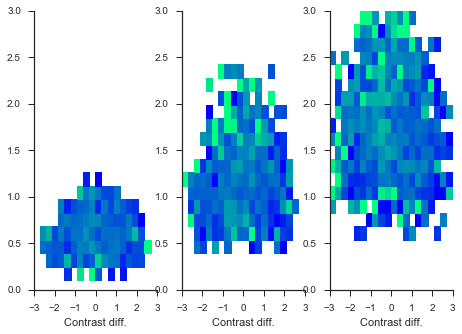

In [136]:
fig = figure(figsize=(7.5, 5))
bins = [linspace(0.1, 3.,21), linspace(-3,3,21)]

for i, (ns, d) in enumerate(dz.query('session_num==4').groupby('noise_sigma')): 
    subplot(1,3,i+1)
    p = d.groupby([empirical.cut(d.mc, bins[1]), 
                    empirical.cut(d.stdc, bins[0])]).choice_rt.median()
    Z = pd.pivot_table(p.reset_index(), index='mc', columns='stdc')

    pcolormesh(bins[1], bins[0], np.ma.masked_invalid(Z.T), vmin=.2, vmax=.55, cmap='winter')
    #colorbar()
    xlabel('Contrast diff.')
    sns.despine()